In [1]:
from utils import *
from torchvision.datasets import ImageFolder
from dataset import Rxrx1
from torch.utils.data import DataLoader

config = load_yaml("/homes/nmorelli/aibio_nico/config/head_conf.yaml")
device = load_device(config)

+--------------------+---------------------------------------------------------------------------+
|               Name |                                                                     Value |
+--------------------+---------------------------------------------------------------------------+
|                net |                                                                    simclr |
|      backbone_name |                                                                 vit_small |
|     checkpoint_dir |                                     /homes/nmorelli/aibio_nico/checkpoint |
|        dataset_dir |                                                   /work/ai4bio2024/rxrx1/ |
|    load_checkpoint |                                                                      None |
|      load_backbone |                      /homes/nmorelli/aibio_nico/checkpoint/vit_small_norm |
|      metadata_path | /work/h2020deciderficarra_shared/rxrx1/metadata/m_3c_experiment_strat.csv |
|         

In [2]:
dataset = Rxrx1(root_dir = config["dataset_dir"], metadata_path=config["metadata_path"], dataset_norm=config["dataset_norm"])

In [10]:
from head import head_main
net, losser, opt, sched = config_loader(config, dataset)
net = head_main.load_backbone(net, config)
net = net.to(device)
# tr_ = Trainer(net, device, config, opt, losser, collate=None, scheduler=sched)

<All keys matched successfully>
Weight found and loaded!!!/homes/nmorelli/aibio_nico/checkpoint/vit_small_norm


In [4]:
tmp = list(net.parameters())

In [11]:
sched_values = []
for i in range(15):
    sched_values.append(sched.get_last_lr()[0])
    sched.step()

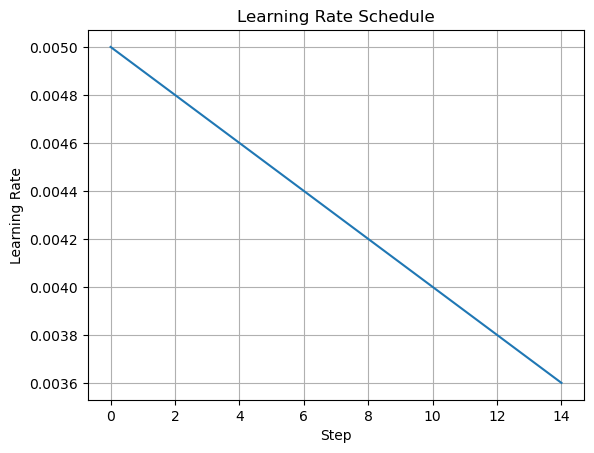

In [12]:
import matplotlib.pyplot as plt

plt.plot(sched_values)
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule")
plt.grid()
plt.show()

In [31]:
np.arange(100000)

array([    0,     1,     2, ..., 99997, 99998, 99999])

In [13]:
def cosine_scheduler(base_value, final_value, epochs, niter_per_ep, warmup_epochs=0, start_warmup_value=0):
    warmup_schedule = np.array([])
    warmup_iters = warmup_epochs * niter_per_ep
    if warmup_epochs > 0:
        warmup_schedule = np.linspace(start_warmup_value, base_value, warmup_iters)

    iters = np.arange(epochs * niter_per_ep - warmup_iters)
    schedule = final_value + 0.5 * (base_value - final_value) * (1 + np.cos(np.pi * iters / len(iters)))

    schedule = np.concatenate((warmup_schedule, schedule))
    assert len(schedule) == epochs * niter_per_ep
    return schedule


momentum_schedule = cosine_scheduler(0.9995, 1,
                                             epochs=config["epochs"], niter_per_ep=len(dataset)// config["epochs"])

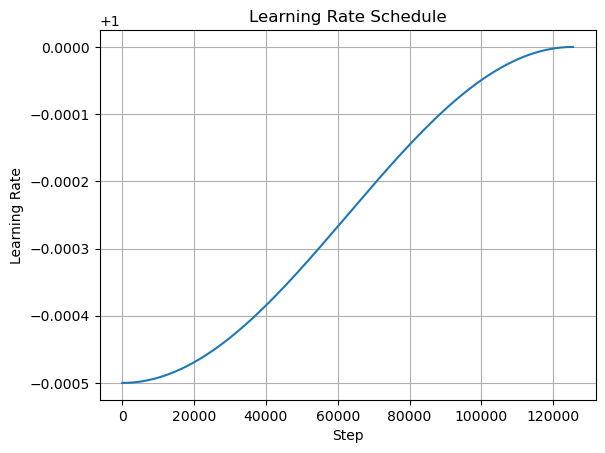

In [ ]:
plt.plot(momentum_schedule)
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule")
plt.grid()
plt.show()

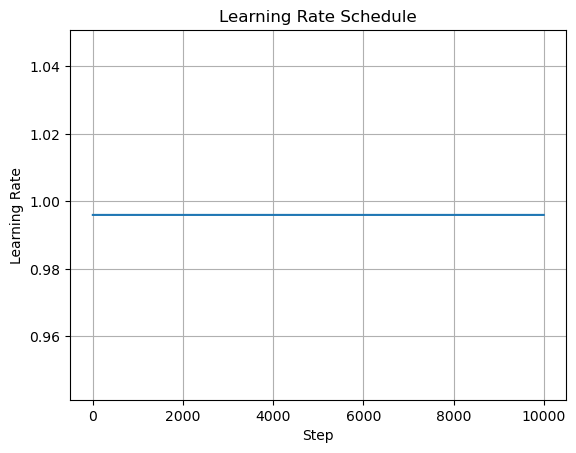

In [15]:
v = []
for i in range(10000):
    momentum = 0.996 + (1.0 - 0.996) * (i/ len(dataset)// config["epochs"])  # or using a cosine schedule
    v.append(momentum)
    # for param_teacher, param_student in zip(teacher.parameters(), student.parameters()):
        # param_teacher.data.mul_(momentum).add_(param_student.data, alpha=1 - momentum)
plt.plot(v)
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule")
plt.grid()
plt.show()

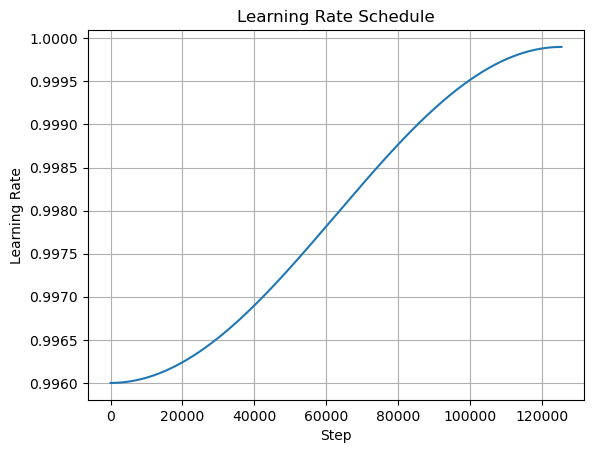

In [20]:
class CosineScheduler:
    def __init__(self, base_value, final_value, total_iters, warmup_iters=0, start_warmup_value=0):
        self.base_value = base_value
        self.final_value = final_value
        self.total_iters = total_iters
        self.warmup_iters = warmup_iters
        self.start_warmup_value = start_warmup_value

    def __call__(self, iteration):
        if iteration < self.warmup_iters:
            return self.start_warmup_value + (self.base_value - self.start_warmup_value) * iteration / self.warmup_iters
        elif iteration >= self.total_iters:
            return self.final_value
        else:
            return self.final_value + 0.5 * (self.base_value - self.final_value) * \
                (1 + math.cos(math.pi * (iteration - self.warmup_iters) / (self.total_iters - self.warmup_iters)))
momentum_scheduler = CosineScheduler(
    base_value=0.996,   # Initial momentum
    final_value=0.9999, # Final momentum
    total_iters=config["epochs"] * len(dataset)// config["epochs"]
)

v = []
for i in range(config["epochs"]):
    for j in range( len(dataset)// config["epochs"]):
        v.append(momentum_scheduler(i*len(dataset)// config["epochs"] + j))

plt.plot(v)
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule")
plt.grid()
plt.show()

In [18]:
momentum_scheduler